In [1]:
import pandas as pd
import numpy as np
import datetime 
import optuna 
import xgboost
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Foosh\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
os.listdir('data')
X_test = pd.read_csv(os.path.join(*['data', 'X_test.csv']), index_col = 0).reset_index(drop = True)
X_train = pd.read_csv(os.path.join(*['data', 'X_train.csv']), index_col = 0).reset_index(drop = True)
Y_test = pd.read_csv(os.path.join(*['data', 'Y_test.csv']), index_col = 0).reset_index(drop = True)
Y_train = pd.read_csv(os.path.join(*['data', 'Y_train.csv']), index_col = 0).reset_index(drop = True)

In [4]:
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)
X_train.head()

(11640, 493)
(46530, 493)
(11640, 1)
(46530, 1)


,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

In [5]:
# X_train = X_train.drop_duplicates().reset_index(drop = True).copy()
# X_test = X_test.drop_duplicates().reset_index(drop = True).copy()

In [6]:
X_train['developers'] = X_train['developers'].apply(lambda x: eval(x))
X_train['publishers'] = X_train['publishers'].apply(lambda x: eval(x))
X_train['languages'] = X_train['languages'].apply(lambda x: eval(x))

### Feature Engineering

In [7]:
category_list = ['1980s', "1990's", '2.5D', '2D', '2D Fighter', '2D Platformer', '360 Video', '3D', '3D Fighter', '3D Platformer', '3D Vision', '4 Player Local', '4X', '6DOF', 'Abstract', 'Accounting', 'Action', 'Action RPG', 'Action RTS', 'Action Roguelike', 'Action-Adventure', 'Addictive', 'Adventure', 'Agriculture', 'Aliens', 'Alternate History', 'Ambient', 'America', 'Animation & Modeling', 'Anime', 'Arcade', 'Archery', 'Arena Shooter', 'Artificial Intelligence', 'Assassin', 'Asymmetric VR', 'Asynchronous Multiplayer', 'Atmospheric', 'Audio Production', 'Auto Battler', 'Automation', 'Automobile Sim', 'BMX', 'Base-Building', 'Baseball', 'Based On A Novel', 'Basketball', 'Battle Royale', "Beat 'em up", 'Beautiful', 'Benchmark', 'Bikes', 'Blood', 'Board Game', 'Boss Rush', 'Bowling', 'Boxing', 'Building', 'Bullet Hell', 'Bullet Time', 'CRPG', 'Capitalism', 'Captions available', 'Card Battler', 'Card Game', 'Cartoon', 'Cartoony', 'Casual', 'Cats', 'Character Action Game', 'Character Customization', 'Chess', 'Choices Matter', 'Choose Your Own Adventure', 'Cinematic', 'City Builder', 'Class-Based', 'Classic', 'Clicker', 'Co-op', 'Co-op Campaign', 'Coding', 'Cold War', 'Collectathon', 'Colony Sim', 'Colorful', 'Combat', 'Combat Racing', 'Comedy', 'Comic Book', 'Commentary available', 'Competitive', 'Conspiracy', 'Controller', 'Conversation', 'Cooking', 'Cozy', 'Crafting', 'Creature Collector', 'Cricket', 'Crime', 'Cross-Platform Multiplayer', 'Cult Classic', 'Cute', 'Cyberpunk', 'Cycling', 'Dark', 'Dark Comedy', 'Dark Fantasy', 'Dark Humor', 'Dating Sim', 'Deckbuilding', 'Demons', 'Design & Illustration', 'Destruction', 'Detective', 'Difficult', 'Dinosaurs', 'Diplomacy', 'Documentary', 'Dog', 'Dragons', 'Drama', 'Driving', 'Dungeon Crawler', 'Dungeons & Dragons', 'Dynamic Narration', 'Dystopian ', 'Early Access', 'Economy', 'Education', 'Electronic', 'Electronic Music', 'Emotional', 'Epic', 'Episodic', 'Escape Room', 'Experience', 'Experimental', 'Exploration', 'FMV', 'FPS', 'Faith', 'Family Friendly', 'Fantasy', 'Farming', 'Farming Sim', 'Fast-Paced', 'Female Protagonist', 'Fighting', 'First-Person', 'Fishing', 'Flight', 'Football (American)', 'Football (Soccer)', 'Foreign', 'Free to Play', 'Full controller support', 'Funny', 'Futuristic', 'Gambling', 'Game Development', 'GameMaker', 'Games Workshop', 'Gaming', 'God Game', 'Golf', 'Gore', 'Gothic', 'Grand Strategy', 'Great Soundtrack', 'Grid-Based Movement', 'Gun Customization', 'Hack and Slash', 'Hacking', 'Hand-drawn', 'Heist', 'Hentai', 'Hero Shooter', 'Hex Grid', 'Hidden Object', 'Historical', 'Hockey', 'Horror', 'Horses', 'Hunting', 'Idler', 'Illuminati', 'Immersive', 'Immersive Sim', 'In-App Purchases', 'Includes Source SDK', 'Includes level editor', 'Indie', 'Instrumental Music', 'Intentionally Awkward Controls', 'Interactive Fiction', 'Inventory Management', 'Investigation', 'Isometric', 'JRPG', 'Jet', 'Job Simulator', 'Jump Scare', 'Kickstarter', 'LAN Co-op', 'LAN PvP', 'LEGO', 'LGBTQ+', 'Lemmings', 'Level Editor', 'Life Sim', 'Linear', 'Local Co-Op', 'Local Multiplayer', 'Logic', 'Loot', 'Looter Shooter', 'Lore-Rich', 'Lovecraftian', 'MMO', 'MMORPG', 'MOBA', 'Magic', 'Mahjong', 'Management', 'Mars', 'Martial Arts', 'Massively Multiplayer', 'Match 3', 'Mature', 'Mechs', 'Medical Sim', 'Medieval', 'Memes', 'Metroidvania', 'Military', 'Mini Golf', 'Minigames', 'Minimalist', 'Mining', 'Mod', 'Moddable', 'Modern', 'Motocross', 'Motorbike', 'Mouse only', 'Movie', 'Multi-player', 'Multiplayer', 'Multiple Endings', 'Music', 'Music-Based Procedural Generation', 'Musou', 'Mystery', 'Mystery Dungeon', 'Mythology', 'NSFW', 'Narration', 'Narrative', 'Nature', 'Naval', 'Naval Combat', 'Ninja', 'Noir', 'Nonlinear', 'Nostalgia', 'Nudity', 'Offroad', 'Old School', 'On-Rails Shooter', 'Online Co-Op', 'Online Co-op', 'Online PvP', 'Open World', 'Open World Survival Craft', 'Otome', 'Outbreak Sim', 'Parkour', 'Parody ', 'Partial Controller Support', 'Party', 'Party Game', 'Party-Based RPG', 'Perma Death', 'Philosophical', 'Photo Editing', 'Physics', 'Pinball', 'Pirates', 'Pixel Graphics', 'Platformer', 'Point & Click', 'Political', 'Political Sim', 'Politics', 'Pool', 'Post-apocalyptic', 'Precision Platformer', 'Procedural Generation', 'Programming', 'Psychedelic', 'Psychological', 'Psychological Horror', 'Puzzle', 'Puzzle-Platformer', 'PvE', 'PvP', 'Quick-Time Events', 'RPG', 'RPGMaker', 'RTS', 'Racing', 'Real Time Tactics', 'Real-Time', 'Real-Time with Pause', 'Realistic', 'Reboot', 'Relaxing', 'Remake', 'Remote Play Together', 'Remote Play on Phone', 'Remote Play on TV', 'Remote Play on Tablet', 'Replay Value', 'Resource Management', 'Retro', 'Rhythm', 'Robots', 'Rock Music', 'Rogue-like', 'Rogue-lite', 'Roguelike Deckbuilder', 'Roguevania', 'Romance', 'Rome', 'Rugby', 'Runner', 'Sailing', 'Sandbox', 'Satire', 'Sci-fi', 'Science', 'Score Attack', 'Sexual Content', 'Shared/Split Screen', 'Shared/Split Screen Co-op', 'Shared/Split Screen PvP', "Shoot 'Em Up", 'Shooter', 'Shop Keeper', 'Short', 'Side Scroller', 'Silent Protagonist', 'Simulation', 'Single-player', 'Singleplayer', 'Skateboarding', 'Skating', 'Skiing', 'Sniper', 'Snooker', 'Snow', 'Snowboarding', 'Social Deduction', 'Software', 'Software Training', 'Sokoban', 'Solitaire', 'Solo RV', 'Souls-like', 'Soundtrack', 'Space', 'Space Sim', 'Spaceships', 'Spectacle fighter', 'Spelling', 'Split Screen', 'Sports', 'Stats', 'Stealth', 'Steam Achievements', 'Steam Cloud', 'Steam Leaderboards', 'Steam Trading Cards', 'Steam Turn Notifications', 'Steam Workshop', 'SteamVR Collectibles', 'Steampunk', 'Story Rich', 'Strategy', 'Strategy RPG', 'Stylized', 'Submarine', 'Superhero', 'Supernatural', 'Surreal', 'Survival', 'Survival Horror', 'Swordplay', 'Tabletop', 'Tactical', 'Tactical RPG', 'Tanks', 'Team-Based', 'Tennis', 'Text-Based', 'Third Person', 'Third-Person Shooter', 'Thriller', 'Tile-Matching', 'Time Attack', 'Time Management', 'Time Manipulation', 'Time Travel', 'Top-Down', 'Top-Down Shooter', 'Touch-Friendly', 'Tower Defense', 'TrackIR', 'Tracked Controller Support', 'Trading', 'Trading Card Game', 'Traditional Roguelike', 'Trains', 'Transhumanism', 'Transportation', 'Trivia', 'Turn-Based', 'Turn-Based Combat', 'Turn-Based Strategy', 'Turn-Based Tactics', 'Tutorial', 'Twin Stick Shooter', 'Typing', 'Underground', 'Underwater', 'Unforgiving', 'Utilities', 'VR', 'VR Only', 'VR Support', 'VR Supported', 'Valve Anti-Cheat enabled', 'Vampire', 'Vehicular Combat', 'Video Production', 'Vikings', 'Villain Protagonist', 'Violent', 'Visual Novel', 'Voice Control', 'Volleyball', 'Voxel', 'Walking Simulator', 'War', 'Wargame', 'Warhammer 40K', 'Web Publishing', 'Werewolves', 'Western', 'Wholesome', 'Word Game', 'World War I', 'World War II', 'Wrestling', 'Zombies', 'e-sports',]

In [8]:
#Count the number of categories in a game 
X_train['num_categories'] = X_train[category_list].sum(axis = 1)
X_test['num_categories'] = X_test[category_list].sum(axis = 1)

In [9]:
#Count number of languages in a game 
X_train['num_languages'] = X_train['languages'].apply(len)
X_test['num_languages'] = X_test['languages'].apply(len)

In [10]:
#Count number of developers and publishers
X_train['num_developers'] = X_train['developers'].apply(len)
X_train['num_publishers'] = X_train['publishers'].apply(len)
X_test['num_developers'] = X_test['developers'].apply(len)
X_test['num_publishers'] = X_test['publishers'].apply(len)

In [11]:
#One hot encode languages
languages = {}
for avail_languages in X_train['languages']:
    for lang in avail_languages:
        lang = lang.strip()
        if lang in languages:
            languages[lang] += 1
        else:
            languages[lang] = 1
languages

{'English': 46092,
 'German': 11259,
 'Simplified Chinese': 10681,
 'Traditional Chinese': 5160,
 'French': 10835,
 'Italian': 7457,
 'Spanish - Spain': 9895,
 'Danish': 1370,
 'Ukrainian': 1638,
 'Russian': 10471,
 'Bulgarian': 1037,
 'Hungarian': 1517,
 'Turkish': 2914,
 'Greek': 1172,
 'Norwegian': 1303,
 'Czech': 1879,
 'Japanese': 8633,
 'Polish': 4236,
 'Thai': 1394,
 'Swedish': 1650,
 'Romanian': 1179,
 'Finnish': 1306,
 'Dutch': 2487,
 'Portuguese - Portugal': 3272,
 'Portuguese - Brazil': 5511,
 'Arabic': 1472,
 'Korean': 5322,
 'Spanish - Latin America': 2324,
 'Vietnamese': 942,
 'Catalan': 37,
 'Not supported': 1138,
 'Persian': 16,
 'Slovak': 47,
 'Belarusian': 30,
 'Indonesian': 67,
 'Croatian': 12,
 'Estonian': 8,
 'Afrikaans': 5,
 'Hebrew': 24,
 'Albanian': 7,
 'Azerbaijani': 7,
 'Kazakh': 4,
 'Lithuanian': 9,
 'Malay': 22,
 'Slovenian': 5,
 'Serbian': 19,
 'Basque': 13,
 'Galician': 9,
 'Bangla': 9,
 'Bosnian': 5,
 'Georgian': 4,
 'Hindi': 33,
 'Latvian': 11,
 'Urdu': 

In [12]:
del languages['English[b]*[/b]']
del languages['French[b]*[/b]']
del languages['Italian[b]*[/b]']
del languages['German[b]*[/b]']
del languages['Spanish - Spain[b]*[/b]']
del languages['Korean[b]*[/b]']
del languages['Japanese \r\n\r\n[b]*[/b]']
del languages['Russian\r\n[b]*[/b]']
del languages['#lang_slovakian']
del languages['(all with full audio support)']
del languages[ 'English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech']

In [13]:
lang_dict_train = {}
for language in languages.keys():
    lang_dict_train[language] = []
    for avail_languages in X_train['languages']:
        if language in [x.strip() for x in avail_languages]:
            lang_dict_train[language].append(1)
        else:
            lang_dict_train[language].append(0)
            
lang_dict_test = {}
for language in languages.keys():
    lang_dict_test[language] = []
    for avail_languages in X_test['languages']:
        if language in [x.strip() for x in avail_languages]:
            lang_dict_test[language].append(1)
        else:
            lang_dict_test[language].append(0)

In [14]:
X_train = pd.concat([X_train, pd.DataFrame(lang_dict_train)], axis = 1)
X_test = pd.concat([X_test, pd.DataFrame(lang_dict_test)], axis = 1)
print(X_train.shape)
print(X_test.shape)

display(X_train.head())
display(X_test.head())

(46530, 570)
(11640, 570)


,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

In [15]:
#One hot encode developers and publishers 
developers = {}
for devs in X_train['developers']:
    for dev in devs:
        dev = dev.strip()
        if dev in developers:
            developers[dev] += 1
        else:
            developers[dev] = 1
developers = pd.Series(developers).sort_values(ascending = False)

In [16]:
publishers = {}
for pubs in X_train['publishers']:
    for pub in pubs:
        pub = pub.strip()
        if pub in publishers:
            publishers[pub] += 1
        else:
            publishers[pub] = 1

publishers = pd.Series(publishers).sort_values(ascending = False)

In [17]:
print(X_train.shape)
print(X_test.shape)

(46530, 570)
(11640, 570)


In [18]:
#Take top 30 developers and publishers and do 1 hot encoding
top_30_devs = set(developers.iloc[0:30].index)
top_30_pubs = set(publishers.iloc[0:30].index)

dev_dict_train = {}
for top_dev in top_30_devs:
    dev_dict_train[f"{top_dev}_dev"] = []
    for devs in X_train['developers']:
        if top_dev in [x.strip() for x in devs]:
            dev_dict_train[f"{top_dev}_dev"].append(1)
        else:
            dev_dict_train[f"{top_dev}_dev"].append(0)
            
pub_dict_train = {}
for top_pub in top_30_pubs:
    pub_dict_train[f"{top_pub}_pub"] = []
    for pubs in X_train['publishers']:
        if top_pub in [x.strip() for x in pubs]:
            pub_dict_train[f"{top_pub}_pub"].append(1)
        else:
            pub_dict_train[f"{top_pub}_pub"].append(0)

dev_dict_test = {}
for top_dev in top_30_devs:
    dev_dict_test[f"{top_dev}_dev"] = []
    for devs in X_test['developers']:
        if top_dev in [x.strip() for x in devs]:
            dev_dict_test[f"{top_dev}_dev"].append(1)
        else:
            dev_dict_test[f"{top_dev}_dev"].append(0)
            
pub_dict_test = {}
for top_pub in top_30_pubs:
    pub_dict_test[f"{top_pub}_pub"] = []
    for pubs in X_test['publishers']:
        if top_pub in [x.strip() for x in pubs]:
            pub_dict_test[f"{top_pub}_pub"].append(1)
        else:
            pub_dict_test[f"{top_pub}_pub"].append(0)

In [19]:
X_train = pd.concat([X_train, pd.DataFrame(dev_dict_train), pd.DataFrame(pub_dict_train)], axis = 1)
X_test = pd.concat([X_test, pd.DataFrame(dev_dict_test), pd.DataFrame(pub_dict_test)], axis = 1)
print(X_train.shape)
print(X_test.shape)
display(X_train.head())
display(X_test.head())

(46530, 630)
(11640, 630)


,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

In [20]:
X_train.drop(['appid', 'type', 'name', 'release_date', 'developers', 'publishers', 'languages'], axis = 1, inplace = True)
X_test.drop(['appid', 'type', 'name', 'release_date', 'developers', 'publishers', 'languages'], axis = 1, inplace = True)

### Modelling

In [21]:
Y_train = Y_train.values.squeeze()
Y_test = Y_test.values.squeeze()

In [22]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

In [23]:
print(accuracy_score(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred, average = 'macro'))

0.7701030927835052
0.4062893296114562


In [24]:
feat_importances = pd.DataFrame(pd.Series(clf.feature_importances_, clf.feature_names_in_)).sort_values(0).head(20)
feat_importances

,0
Jump Scare,0.000000e+00
Telugu,0.000000e+00
Punjabi (Gurmukhi),1.581042e-09
Swahili,3.128396e-09
Instrumental Music,5.042854e-09
Mongolian,1.133979e-08
Tamil,2.803714e-08
Maori,3.656782e-08
Electronic,5.183891e-08
Volleyball,5.546836e-08


In [25]:
print(X_train['Khmer'].sum())
print(X_train['Mongolian'].sum())
print(X_train['Telugu'].sum())

1
1
1


Going to prune unimportant features first, there are too many columns in this dataset. Prune the one hot encode features that have too little values in them.

In [26]:
top_30_langs = set(pd.Series(languages).sort_values(ascending = False).iloc[0:30].index)

In [27]:
language_list = list(languages.keys())

In [28]:
categories_count = X_train[category_list].sum(axis = 0)
top_50_categories = set(categories_count.sort_values(ascending = False).iloc[0:50].index)

In [29]:
new_cols = [x for x in list(X_train.columns) if x not in set(set(category_list) - top_50_categories)]
new_cols = [x for x in list(new_cols) if x not in set(set(language_list) - top_30_langs)]
X_train = X_train.loc[:, new_cols]
X_test = X_test.loc[:, new_cols]

In [30]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

In [31]:
print(accuracy_score(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred, average = 'macro'))

0.7762027491408935
0.4478171699406369


In [32]:
feat_importances = pd.DataFrame(pd.Series(clf.feature_importances_, clf.feature_names_in_)).sort_values(0, ascending = False)
feat_importances.head(20)

,0
positive_ratings,0.119960
negative_ratings,0.116665
average_playtime,0.075645
days_since_released,0.059697
Ratings,0.055902
months_since_released,0.050659
steamspy_price,0.034889
years_since_released,0.033180
store_difference_price,0.032772
num_categories,0.028660


In [33]:
feat_importances.tail(20)

,0
Hosted Games_pub,0.000091
Valkeala Software_dev,0.000088
Sokpop Collective_pub,0.000075
Ripknot Systems_dev,0.000074
Blender Games_dev,0.000062
Sokpop Collective_dev,0.000057
8floor_pub,0.000051
ImperiumGame_dev,0.000034
Atomic Fabrik_dev,0.000033
Eipix Entertainment_dev,0.000027


Model performance remains the same, honestly can prune further features, most still seem quite irrelevant


### Hyperparameter tuning

Do hyperparameter tuning with cross validation

In [34]:
import lightgbm
from sklearn.model_selection import KFold
print(lightgbm.__version__)

C:\Users\Foosh\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Foosh\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Foosh\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


3.3.5


In [35]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

##### Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
tree_clf = DecisionTreeClassifier(max_depth = 4)
tree_clf.fit(X_train, Y_train)
Y_pred = tree_clf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred, average = 'macro'))

0.7471649484536083
0.4416683834176928


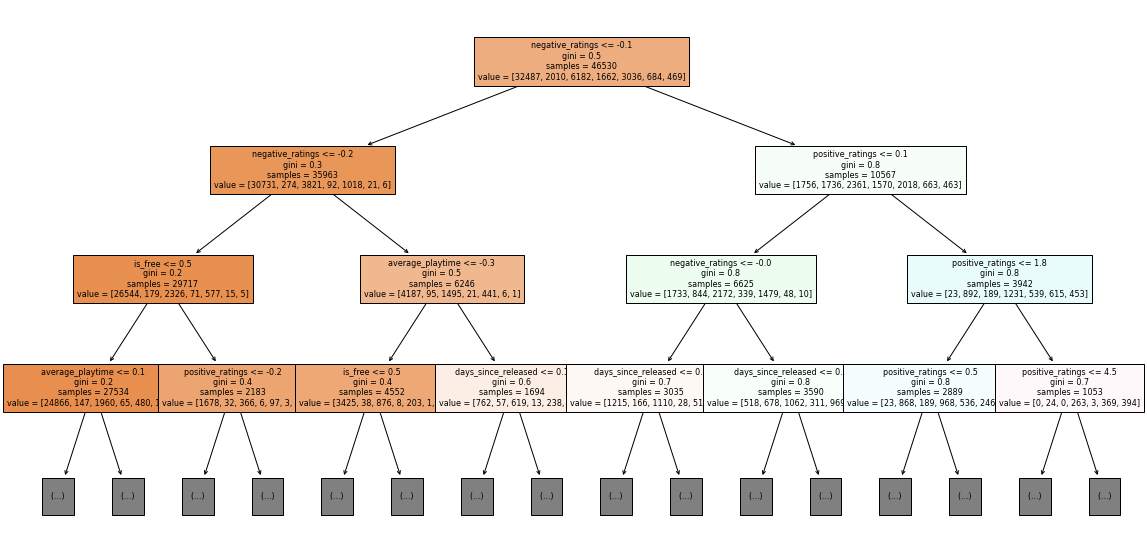

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))  # set plot size (denoted in inches)
plot_tree(tree_clf, fontsize = 8, max_depth = 3, feature_names = tree_clf.feature_names_in_, filled = True, precision = 1)
plt.show()


##### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression(max_iter = 1000)
logreg_clf.fit(X_train, Y_train)
Y_pred = logreg_clf.predict(X_test)
print(accuracy_score(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred, average = 'macro'))

0.2555841924398625
0.17834381420907333


C:\Users\Foosh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### GBM Baseline Model

In [149]:
clf = lightgbm.LGBMClassifier(objective = 'multiclass')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

In [150]:
print(accuracy_score(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred, average = 'macro'))

0.7654639175257731
0.4620024440546312


In [151]:
Y_train = pd.Series(Y_train)
Y_test = pd.Series(Y_test)

##### Hyperparameter tuning

In [154]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=False)
    accuracys = []
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 6, 64), 
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0,1),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }
    for train_index, test_index in kf.split(X_train):
        cv_train_X, cv_train_Y = X_train.iloc[train_index], Y_train.iloc[train_index]
        cv_test_X, cv_test_Y = X_train.iloc[test_index], Y_train.iloc[test_index]
        lightgbm_clf = lightgbm.LGBMClassifier(objective = 'multiclass', **params)
        lightgbm_clf.fit(cv_train_X, cv_train_Y)
        cv_pred_Y = lightgbm_clf.predict(cv_test_X)
        accuracys.append(f1_score(cv_test_Y, cv_pred_Y, average = 'macro'))
    return np.mean(accuracys)
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials=20)

[I 2023-04-09 19:11:13,057] A new study created in memory with name: no-name-69c60cbe-d181-42e6-becf-9cce610ddafe
[I 2023-04-09 19:11:33,938] Trial 0 finished with value: 0.5236276160176166 and parameters: {'num_leaves': 36, 'max_depth': 8, 'n_estimators': 141, 'reg_alpha': 0.017190705774228432, 'reg_lambda': 0.23949745504772602, 'class_weight': None}. Best is trial 0 with value: 0.5236276160176166.
[I 2023-04-09 19:11:41,433] Trial 1 finished with value: 0.5088110421580713 and parameters: {'num_leaves': 19, 'max_depth': 3, 'n_estimators': 125, 'reg_alpha': 0.5063189353690412, 'reg_lambda': 0.9681705909593239, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5236276160176166.
[I 2023-04-09 19:12:11,550] Trial 2 finished with value: 0.5233379067386299 and parameters: {'num_leaves': 32, 'max_depth': 5, 'n_estimators': 338, 'reg_alpha': 0.10531224469503186, 'reg_lambda': 0.3673013592001285, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5236276160176166.
[I 2023-04-0

In [42]:
# best_params = study.best_params
lightgbm_clf = lightgbm.LGBMClassifier(objective='multiclass', **{'num_leaves': 47, 'max_depth': 8, 'n_estimators': 245, 'reg_alpha': 0.8746789332736401, 'reg_lambda': 0.9066048979713516})
lightgbm_clf.fit(X_train, Y_train)
Y_pred = lightgbm_clf.predict(X_test)
print(f"Acc: {accuracy_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred, average = 'macro')}")

Acc: 0.7764604810996564
F1: 0.4995033910160133


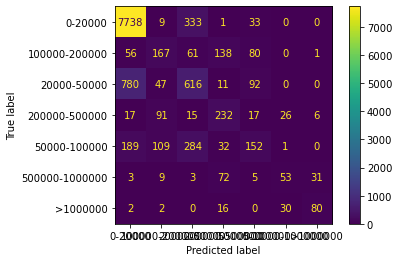

In [162]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
labels = Y_train.unique()
a = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred, labels = lightgbm_clf.classes_),display_labels= lightgbm_clf.classes_)
a.plot()

#### Summary of Table

|Model| Accuracy | Macro F1 | 
|---|---|---|
|Logistic Regression| 0.2542 | 0.1749 | 
|Decision Tree| 0.7471 | 0.4416 | 
|Random Forest| 0.7774 | 0.4486 | 
|lightgbm (Gradient Boost)| 0.77646 | 0.4995 | 


##### Feature Importance

In [43]:
importance = pd.DataFrame({"importance":lightgbm_clf.feature_importances_, "names":lightgbm_clf.feature_name_}).sort_values('importance', ascending = False)
importance.head(30)

,importance,names
66,8044,Ratings
9,7772,days_since_released
3,7534,negative_ratings
2,6911,positive_ratings
4,5982,average_playtime
67,4677,store_difference_price
5,4384,steamspy_price
68,3894,num_categories
65,3433,discount_percent
69,2907,num_languages


In [44]:
importance.tail(30)

,importance,names
149,5,HHGames_pub
135,5,ElectronicArts_pub
161,4,SlitherineLtd_pub
115,4,SquareEnix_dev
128,4,SEGA_dev
125,4,ValkealaSoftware_dev
150,3,SAIndustry_pub
130,2,HostedGames_dev
151,2,TeroLunkka_pub
118,2,LuciEntertainment_dev


Most of these features come from the gameplay. See if we can make a prediction soley on the characteristics of the games so it can be useful before the game is released. Readd all languages, category developers etc. 

In [164]:
X_test = pd.read_csv(os.path.join(*['data', 'X_test.csv']), index_col = 0).reset_index(drop = True)
X_train = pd.read_csv(os.path.join(*['data', 'X_train.csv']), index_col = 0).reset_index(drop = True)
Y_test = pd.read_csv(os.path.join(*['data', 'Y_test.csv']), index_col = 0).reset_index(drop = True)
Y_train = pd.read_csv(os.path.join(*['data', 'Y_train.csv']), index_col = 0).reset_index(drop = True)

In [165]:
X_train['developers'] = X_train['developers'].apply(lambda x: eval(x))
X_train['publishers'] = X_train['publishers'].apply(lambda x: eval(x))
X_train['languages'] = X_train['languages'].apply(lambda x: eval(x))

In [166]:
category_list = ['1980s', "1990's", '2.5D', '2D', '2D Fighter', '2D Platformer', '360 Video', '3D', '3D Fighter', '3D Platformer', '3D Vision', '4 Player Local', '4X', '6DOF', 'Abstract', 'Accounting', 'Action', 'Action RPG', 'Action RTS', 'Action Roguelike', 'Action-Adventure', 'Addictive', 'Adventure', 'Agriculture', 'Aliens', 'Alternate History', 'Ambient', 'America', 'Animation & Modeling', 'Anime', 'Arcade', 'Archery', 'Arena Shooter', 'Artificial Intelligence', 'Assassin', 'Asymmetric VR', 'Asynchronous Multiplayer', 'Atmospheric', 'Audio Production', 'Auto Battler', 'Automation', 'Automobile Sim', 'BMX', 'Base-Building', 'Baseball', 'Based On A Novel', 'Basketball', 'Battle Royale', "Beat 'em up", 'Beautiful', 'Benchmark', 'Bikes', 'Blood', 'Board Game', 'Boss Rush', 'Bowling', 'Boxing', 'Building', 'Bullet Hell', 'Bullet Time', 'CRPG', 'Capitalism', 'Captions available', 'Card Battler', 'Card Game', 'Cartoon', 'Cartoony', 'Casual', 'Cats', 'Character Action Game', 'Character Customization', 'Chess', 'Choices Matter', 'Choose Your Own Adventure', 'Cinematic', 'City Builder', 'Class-Based', 'Classic', 'Clicker', 'Co-op', 'Co-op Campaign', 'Coding', 'Cold War', 'Collectathon', 'Colony Sim', 'Colorful', 'Combat', 'Combat Racing', 'Comedy', 'Comic Book', 'Commentary available', 'Competitive', 'Conspiracy', 'Controller', 'Conversation', 'Cooking', 'Cozy', 'Crafting', 'Creature Collector', 'Cricket', 'Crime', 'Cross-Platform Multiplayer', 'Cult Classic', 'Cute', 'Cyberpunk', 'Cycling', 'Dark', 'Dark Comedy', 'Dark Fantasy', 'Dark Humor', 'Dating Sim', 'Deckbuilding', 'Demons', 'Design & Illustration', 'Destruction', 'Detective', 'Difficult', 'Dinosaurs', 'Diplomacy', 'Documentary', 'Dog', 'Dragons', 'Drama', 'Driving', 'Dungeon Crawler', 'Dungeons & Dragons', 'Dynamic Narration', 'Dystopian ', 'Early Access', 'Economy', 'Education', 'Electronic', 'Electronic Music', 'Emotional', 'Epic', 'Episodic', 'Escape Room', 'Experience', 'Experimental', 'Exploration', 'FMV', 'FPS', 'Faith', 'Family Friendly', 'Fantasy', 'Farming', 'Farming Sim', 'Fast-Paced', 'Female Protagonist', 'Fighting', 'First-Person', 'Fishing', 'Flight', 'Football (American)', 'Football (Soccer)', 'Foreign', 'Free to Play', 'Full controller support', 'Funny', 'Futuristic', 'Gambling', 'Game Development', 'GameMaker', 'Games Workshop', 'Gaming', 'God Game', 'Golf', 'Gore', 'Gothic', 'Grand Strategy', 'Great Soundtrack', 'Grid-Based Movement', 'Gun Customization', 'Hack and Slash', 'Hacking', 'Hand-drawn', 'Heist', 'Hentai', 'Hero Shooter', 'Hex Grid', 'Hidden Object', 'Historical', 'Hockey', 'Horror', 'Horses', 'Hunting', 'Idler', 'Illuminati', 'Immersive', 'Immersive Sim', 'In-App Purchases', 'Includes Source SDK', 'Includes level editor', 'Indie', 'Instrumental Music', 'Intentionally Awkward Controls', 'Interactive Fiction', 'Inventory Management', 'Investigation', 'Isometric', 'JRPG', 'Jet', 'Job Simulator', 'Jump Scare', 'Kickstarter', 'LAN Co-op', 'LAN PvP', 'LEGO', 'LGBTQ+', 'Lemmings', 'Level Editor', 'Life Sim', 'Linear', 'Local Co-Op', 'Local Multiplayer', 'Logic', 'Loot', 'Looter Shooter', 'Lore-Rich', 'Lovecraftian', 'MMO', 'MMORPG', 'MOBA', 'Magic', 'Mahjong', 'Management', 'Mars', 'Martial Arts', 'Massively Multiplayer', 'Match 3', 'Mature', 'Mechs', 'Medical Sim', 'Medieval', 'Memes', 'Metroidvania', 'Military', 'Mini Golf', 'Minigames', 'Minimalist', 'Mining', 'Mod', 'Moddable', 'Modern', 'Motocross', 'Motorbike', 'Mouse only', 'Movie', 'Multi-player', 'Multiplayer', 'Multiple Endings', 'Music', 'Music-Based Procedural Generation', 'Musou', 'Mystery', 'Mystery Dungeon', 'Mythology', 'NSFW', 'Narration', 'Narrative', 'Nature', 'Naval', 'Naval Combat', 'Ninja', 'Noir', 'Nonlinear', 'Nostalgia', 'Nudity', 'Offroad', 'Old School', 'On-Rails Shooter', 'Online Co-Op', 'Online Co-op', 'Online PvP', 'Open World', 'Open World Survival Craft', 'Otome', 'Outbreak Sim', 'Parkour', 'Parody ', 'Partial Controller Support', 'Party', 'Party Game', 'Party-Based RPG', 'Perma Death', 'Philosophical', 'Photo Editing', 'Physics', 'Pinball', 'Pirates', 'Pixel Graphics', 'Platformer', 'Point & Click', 'Political', 'Political Sim', 'Politics', 'Pool', 'Post-apocalyptic', 'Precision Platformer', 'Procedural Generation', 'Programming', 'Psychedelic', 'Psychological', 'Psychological Horror', 'Puzzle', 'Puzzle-Platformer', 'PvE', 'PvP', 'Quick-Time Events', 'RPG', 'RPGMaker', 'RTS', 'Racing', 'Real Time Tactics', 'Real-Time', 'Real-Time with Pause', 'Realistic', 'Reboot', 'Relaxing', 'Remake', 'Remote Play Together', 'Remote Play on Phone', 'Remote Play on TV', 'Remote Play on Tablet', 'Replay Value', 'Resource Management', 'Retro', 'Rhythm', 'Robots', 'Rock Music', 'Rogue-like', 'Rogue-lite', 'Roguelike Deckbuilder', 'Roguevania', 'Romance', 'Rome', 'Rugby', 'Runner', 'Sailing', 'Sandbox', 'Satire', 'Sci-fi', 'Science', 'Score Attack', 'Sexual Content', 'Shared/Split Screen', 'Shared/Split Screen Co-op', 'Shared/Split Screen PvP', "Shoot 'Em Up", 'Shooter', 'Shop Keeper', 'Short', 'Side Scroller', 'Silent Protagonist', 'Simulation', 'Single-player', 'Singleplayer', 'Skateboarding', 'Skating', 'Skiing', 'Sniper', 'Snooker', 'Snow', 'Snowboarding', 'Social Deduction', 'Software', 'Software Training', 'Sokoban', 'Solitaire', 'Solo RV', 'Souls-like', 'Soundtrack', 'Space', 'Space Sim', 'Spaceships', 'Spectacle fighter', 'Spelling', 'Split Screen', 'Sports', 'Stats', 'Stealth', 'Steam Achievements', 'Steam Cloud', 'Steam Leaderboards', 'Steam Trading Cards', 'Steam Turn Notifications', 'Steam Workshop', 'SteamVR Collectibles', 'Steampunk', 'Story Rich', 'Strategy', 'Strategy RPG', 'Stylized', 'Submarine', 'Superhero', 'Supernatural', 'Surreal', 'Survival', 'Survival Horror', 'Swordplay', 'Tabletop', 'Tactical', 'Tactical RPG', 'Tanks', 'Team-Based', 'Tennis', 'Text-Based', 'Third Person', 'Third-Person Shooter', 'Thriller', 'Tile-Matching', 'Time Attack', 'Time Management', 'Time Manipulation', 'Time Travel', 'Top-Down', 'Top-Down Shooter', 'Touch-Friendly', 'Tower Defense', 'TrackIR', 'Tracked Controller Support', 'Trading', 'Trading Card Game', 'Traditional Roguelike', 'Trains', 'Transhumanism', 'Transportation', 'Trivia', 'Turn-Based', 'Turn-Based Combat', 'Turn-Based Strategy', 'Turn-Based Tactics', 'Tutorial', 'Twin Stick Shooter', 'Typing', 'Underground', 'Underwater', 'Unforgiving', 'Utilities', 'VR', 'VR Only', 'VR Support', 'VR Supported', 'Valve Anti-Cheat enabled', 'Vampire', 'Vehicular Combat', 'Video Production', 'Vikings', 'Villain Protagonist', 'Violent', 'Visual Novel', 'Voice Control', 'Volleyball', 'Voxel', 'Walking Simulator', 'War', 'Wargame', 'Warhammer 40K', 'Web Publishing', 'Werewolves', 'Western', 'Wholesome', 'Word Game', 'World War I', 'World War II', 'Wrestling', 'Zombies', 'e-sports',]

In [167]:
#Count the number of categories in a game 
X_train['num_categories'] = X_train[category_list].sum(axis = 1)
X_test['num_categories'] = X_test[category_list].sum(axis = 1)

In [168]:
#Count number of languages in a game 
X_train['num_languages'] = X_train['languages'].apply(len)
X_test['num_languages'] = X_test['languages'].apply(len)

In [169]:
#Count number of developers and publishers
X_train['num_developers'] = X_train['developers'].apply(len)
X_train['num_publishers'] = X_train['publishers'].apply(len)
X_test['num_developers'] = X_test['developers'].apply(len)
X_test['num_publishers'] = X_test['publishers'].apply(len)

In [170]:
#One hot encode languages
languages = {}
for avail_languages in X_train['languages']:
    for lang in avail_languages:
        lang = lang.strip()
        if lang in languages:
            languages[lang] += 1
        else:
            languages[lang] = 1
languages

{'English': 46092,
 'German': 11259,
 'Simplified Chinese': 10681,
 'Traditional Chinese': 5160,
 'French': 10835,
 'Italian': 7457,
 'Spanish - Spain': 9895,
 'Danish': 1370,
 'Ukrainian': 1638,
 'Russian': 10471,
 'Bulgarian': 1037,
 'Hungarian': 1517,
 'Turkish': 2914,
 'Greek': 1172,
 'Norwegian': 1303,
 'Czech': 1879,
 'Japanese': 8633,
 'Polish': 4236,
 'Thai': 1394,
 'Swedish': 1650,
 'Romanian': 1179,
 'Finnish': 1306,
 'Dutch': 2487,
 'Portuguese - Portugal': 3272,
 'Portuguese - Brazil': 5511,
 'Arabic': 1472,
 'Korean': 5322,
 'Spanish - Latin America': 2324,
 'Vietnamese': 942,
 'Catalan': 37,
 'Not supported': 1138,
 'Persian': 16,
 'Slovak': 47,
 'Belarusian': 30,
 'Indonesian': 67,
 'Croatian': 12,
 'Estonian': 8,
 'Afrikaans': 5,
 'Hebrew': 24,
 'Albanian': 7,
 'Azerbaijani': 7,
 'Kazakh': 4,
 'Lithuanian': 9,
 'Malay': 22,
 'Slovenian': 5,
 'Serbian': 19,
 'Basque': 13,
 'Galician': 9,
 'Bangla': 9,
 'Bosnian': 5,
 'Georgian': 4,
 'Hindi': 33,
 'Latvian': 11,
 'Urdu': 

In [171]:
del languages['English[b]*[/b]']
del languages['French[b]*[/b]']
del languages['Italian[b]*[/b]']
del languages['German[b]*[/b]']
del languages['Spanish - Spain[b]*[/b]']
del languages['Korean[b]*[/b]']
del languages['Japanese \r\n\r\n[b]*[/b]']
del languages['Russian\r\n[b]*[/b]']
del languages['#lang_slovakian']
del languages['(all with full audio support)']
del languages[ 'English\r\nRussian\r\nSpanish - Spain\r\nJapanese\r\nCzech']

In [172]:
lang_dict_train = {}
for language in languages.keys():
    lang_dict_train[language] = []
    for avail_languages in X_train['languages']:
        if language in [x.strip() for x in avail_languages]:
            lang_dict_train[language].append(1)
        else:
            lang_dict_train[language].append(0)
            
lang_dict_test = {}
for language in languages.keys():
    lang_dict_test[language] = []
    for avail_languages in X_test['languages']:
        if language in [x.strip() for x in avail_languages]:
            lang_dict_test[language].append(1)
        else:
            lang_dict_test[language].append(0)

In [173]:
X_train = pd.concat([X_train, pd.DataFrame(lang_dict_train)], axis = 1)
X_test = pd.concat([X_test, pd.DataFrame(lang_dict_test)], axis = 1)
print(X_train.shape)
print(X_test.shape)

display(X_train.head())
display(X_test.head())

(46530, 570)
(11640, 570)


,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

In [174]:
#One hot encode developers and publishers 
developers = {}
for devs in X_train['developers']:
    for dev in devs:
        dev = dev.strip()
        if dev in developers:
            developers[dev] += 1
        else:
            developers[dev] = 1
developers = pd.Series(developers).sort_values(ascending = False)

In [175]:
publishers = {}
for pubs in X_train['publishers']:
    for pub in pubs:
        pub = pub.strip()
        if pub in publishers:
            publishers[pub] += 1
        else:
            publishers[pub] = 1

publishers = pd.Series(publishers).sort_values(ascending = False)

In [176]:
print(len(developers))
print(len(publishers))

31690
25800


In [177]:
top_30_devs = set(developers.iloc[0:500].index)
top_30_pubs = set(publishers.iloc[0:500].index)


dev_dict_train = {}
for top_dev in top_30_devs:
    dev_dict_train[f"{top_dev}_dev"] = []
    for devs in X_train['developers']:
        if top_dev in [x.strip() for x in devs]:
            dev_dict_train[f"{top_dev}_dev"].append(1)
        else:
            dev_dict_train[f"{top_dev}_dev"].append(0)
            
pub_dict_train = {}
for top_pub in top_30_pubs:
    pub_dict_train[f"{top_pub}_pub"] = []
    for pubs in X_train['publishers']:
        if top_pub in [x.strip() for x in pubs]:
            pub_dict_train[f"{top_pub}_pub"].append(1)
        else:
            pub_dict_train[f"{top_pub}_pub"].append(0)

dev_dict_test = {}
for top_dev in top_30_devs:
    dev_dict_test[f"{top_dev}_dev"] = []
    for devs in X_test['developers']:
        if top_dev in [x.strip() for x in devs]:
            dev_dict_test[f"{top_dev}_dev"].append(1)
        else:
            dev_dict_test[f"{top_dev}_dev"].append(0)
            
pub_dict_test = {}
for top_pub in top_30_pubs:
    pub_dict_test[f"{top_pub}_pub"] = []
    for pubs in X_test['publishers']:
        if top_pub in [x.strip() for x in pubs]:
            pub_dict_test[f"{top_pub}_pub"].append(1)
        else:
            pub_dict_test[f"{top_pub}_pub"].append(0)

X_train = pd.concat([X_train, pd.DataFrame(dev_dict_train), pd.DataFrame(pub_dict_train)], axis = 1)
X_test = pd.concat([X_test, pd.DataFrame(dev_dict_test), pd.DataFrame(pub_dict_test)], axis = 1)
print(X_train.shape)
print(X_test.shape)


(46530, 1570)
(11640, 1570)


In [178]:
display(X_train.head())
display(X_test.head())

,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

,appid,type,name,release_date,developers,publishers,required_age,is_free,languages,positive_ratings,negative_ratings,average_playtime,steamspy_price,controller_support,windows,mac,days_since_released,months_since_released,years_since_released,num_dlcs,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,Abstract,Accounting,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,Audio Production,Auto Battler,Automation,Automobile Sim,BMX,Base-Building,Baseball,Based On A Novel,Basketball,Battle Royale,Beat 'em up,Beautiful,Benchmark,Bikes,Blood,Board Game,Boss Rush,Bowling,Boxing,Building,Bullet Hell,Bullet Time,CRPG,Capitalism,Captions available,Card Battler,Card Game,Cartoon,Cartoony,Casual,Cats,Character Action Game,Character Customization,Chess,Choices Matter,Choose Your Own Adventure,Cinematic,City Builder,Class-Based,Classic,Clicker,Co-op,Co-op Campaign,Coding,Cold War,Collectathon,Colony Sim,Colorful,Combat,Combat Racing,Comedy,Comic Book,Commentary available,Competitive,Conspiracy,Controller,Conversation,Cooking,Cozy,Crafting,Creature Collector,Cricket,Crime,Cross-Platform Multiplayer,Cult Classic,Cute,Cyberpunk,Cycling,Dark,Dark Comedy,Dark Fantasy,Dark Humor,Dating Sim,Deckbuilding,Demons,Design & Illustration,Destruction,Detective,Difficult,Dinosaurs,Diplomacy,Documentary,Dog,Dragons,Drama,Driving,Dungeon Crawler,Dungeons & Dragons,Dynamic Narration,Dystopian,Early Access,Economy,Education,Electronic,Electronic Music,Emotional,Epic,Episodic,Escape Room,Experience,Experimental,Exploration,FMV,FPS,Faith,Family Friendly,Fantasy,Farming,Farming Sim,Fast-Paced,Female Protagonist,Fighting,First-Person,Fishing,Flight,Football (American),Football (Soccer),Foreign,Free to Play,Full controller support,Funny,Futuristic,Gambling,Game Development,GameMaker,Games Workshop,Gaming,God Game,Golf,Gore,Gothic,Grand Strategy,Great Soundtrack,Grid-Based Movement,Gun Customization,Hack and Slash,Hacking,Hand-drawn,Heist,Hentai,Hero Shooter,Hex Grid,Hidden Object,Historical,Hockey,Horror,Horses,Hunting,Idler,Illuminati,Immersive,Immersive Sim,In-App Purchases,Includes Source SDK,Includes level editor,Indie,Instrumental Music,Intentionally Awkward Controls,Interactive Fiction,Inventory Management,Investigation,Isometric,JRPG,Jet,Job Simulator,Jump Scare,Kickstarter,LAN Co-op,LAN PvP,LEGO,LGBTQ+,Lemmings,Level Editor,Life Sim,Linear,Local Co-Op,Local Multiplayer,Logic,Loot,Looter Shooter,Lore-Rich,Lovecraftian,MMO,MMORPG,MOBA,Magic,Mahjong,Management,Mars,Martial Arts,Massively Multiplayer,Match 3,Mature,Mechs,Medical Sim,Medieval,Memes,Metroidvania,Military,Mini Golf,Minigames,Minimalist,Mining,Mod,Moddable,Modern,Mods,Motocross,Motorbike,Mouse only,Movie,Multi-player,Multiplayer,Multiple Endings,Music,Music-Based Procedural Generation,Musou,Mystery,Mystery Dungeon,Mythology,NSFW,Narration,Narrative,Nature,Naval,Naval Combat,Ninja,Noir,Nonlinear,Nostalgia,Nudity,Offroad,Old School,On-Rails Shooter,Online Co-Op,Online Co-op,Online PvP,Open World,Open World Survival Craft,Otome,Outbreak Sim,Parkour,Parody,Partial Controller Support,Party,Party Game,Party-Based RPG,Perma Death,Philosophical,Photo Editing,Physics,Pinball,Pirates,Pixel Graphics,Platformer,Point & Click,Political,Political Sim,Politics,Pool,Post-apocalyptic,Precision Platformer,Procedural Generation,Programming,Psychedelic,Psychological,Psychological Horror,Puzzle,Puzzle-Platformer,PvE,PvP,Quick-Time Events,RPG,RPGMaker,RTS,Racing,Real Time Tactics,Real-Time,Real-Time with Pause,Realistic,Reboot,Relaxing,Remake,Remote Play Together,Remote Play on Phone,Remote Play on TV,Remote Play on Tablet,Replay Value,Resource Management,Retro,Rhythm,Robots,Rock Music,Rogue-like,Rogue-lite,Roguelike Deckbuilder,Rog

In [179]:
#Drop all columns that are related to the ratings etc, keep only characteristics + time to account for trend 
X_train_sub = X_train.drop(['appid', 'type', 'name', 'release_date', 'developers', 'publishers', 'languages', 'negative_ratings', 'average_playtime', 'metacritic_score','discount_percent','Ratings','positive_ratings'], axis=1)
X_test_sub = X_test.drop(['appid', 'type', 'name', 'release_date', 'developers', 'publishers', 'languages', 'negative_ratings', 'average_playtime', 'metacritic_score','discount_percent','Ratings','positive_ratings'], axis=1)

In [180]:
print(X_train_sub.shape)
print(X_test_sub.shape)

(46530, 1557)
(11640, 1557)


In [181]:
import re
X_train_sub = X_train_sub.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_sub = X_test_sub.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [182]:
X_train_sub = X_train_sub.loc[:,~X_train_sub.columns.duplicated()].copy()
X_test_sub = X_test_sub.loc[:,~X_test_sub.columns.duplicated()].copy()
X_train_sub.shape

(46530, 1542)

In [183]:
lightgbm_clf = lightgbm.LGBMClassifier(objective='multiclass', **{'num_leaves': 47, 'max_depth': 8, 'n_estimators': 245, 'reg_alpha': 0.8746789332736401, 'reg_lambda': 0.9066048979713516})
lightgbm_clf.fit(X_train_sub, Y_train)
Y_pred = lightgbm_clf.predict(X_test_sub)
print(f"Acc: {accuracy_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred, average = 'macro')}")

C:\Users\Foosh\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Foosh\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acc: 0.7048109965635739
F1: 0.2963035744798664


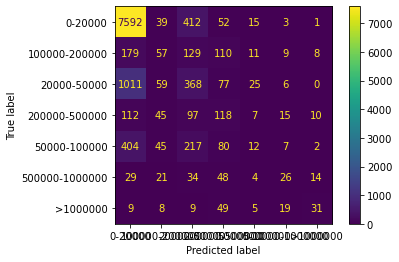

In [184]:
a = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred, labels = lightgbm_clf.classes_),display_labels= lightgbm_clf.classes_)
a.plot()

In [185]:
importance = pd.DataFrame({"importance":lightgbm_clf.feature_importances_, "names":lightgbm_clf.feature_name_}).sort_values('importance', ascending = False)
importance.head(30)

,importance,names
6,8661,days_since_released
477,5871,store_difference_price
2,5001,steamspy_price
478,4181,num_categories
479,3595,num_languages
7,2969,months_since_released
9,1998,num_dlcs
203,631,Indie
5,553,mac
32,526,Adventure
